# Boosting a Decision Stump

The goal of this notebook is to implement your own boosting module.

**Brace yourselves**! This is going to be a fun and challenging assignment.


* Use DataFrames to do some feature engineering.
* Modify the decision trees to incorporate weights.
* Implement Adaboost ensembling.
* Use your implementation of Adaboost to train a boosted decision stump ensemble.
* Evaluate the effect of boosting (adding more decision stumps) on performance of the model.
* Explore the robustness of Adaboost to overfitting.

Let's get started!

# Import Neccessary Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import string
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from numpy.lib.scimath import logn
%matplotlib inline

# Getting the data ready

We will be using the same [LendingClub](https://www.lendingclub.com/) dataset as in the previous assignment.

In [2]:
loans = pd.read_csv('lending-club-data.csv')
loans

c:\users\ahmed ismail khalid\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.143500,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.393200,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.259550,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.275850,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.215330,20141201T000000,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122602,9856168,11708132,6000,6000,6000,60 months,23.40,170.53,E,E5,...,1.0,0.0,1.0,1.0,1,4.487630,20190101T000000,0,1,0
122603,9795013,11647121,15250,15250,15250,36 months,17.57,548.05,D,D2,...,0.4,0.0,0.0,1.0,0,10.117800,20170101T000000,0,0,0
122604,9695736,11547808,8525,8525,8525,60 months,18.25,217.65,D,D3,...,0.6,0.0,1.0,1.0,0,6.958120,20190101T000000,0,1,0
122605,9684700,11536848,22000,22000,22000,60 months,19.97,582.50,D,D5,...,1.0,1.0,0.0,1.0,0,8.961540,20190101T000000,1,0,1


### Extracting the target and the feature columns

We will now repeat some of the feature processing steps that we saw in the previous assignment:

First, we re-assign the target to have +1 as a safe (good) loan, and -1 as a risky (bad) loan.

Next, we select four categorical features: 
1. grade of the loan 
2. the length of the loan term
3. the home ownership status: own, mortgage, rent
4. number of years of employment.

In [3]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans.drop('bad_loans',axis=1)
target = 'safe_loans'
loans = loans[features + [target]]

## One Hot Encoding

In [4]:
catergorical_vars = [var for var in loans.columns if loans[var].dtypes == object]
loans = pd.get_dummies(loans)

## Split data into training and test sets

In [5]:
train_indices = pd.read_json('module-8-assignment-2-train-idx.json')
train_indices = train_indices.rename({0: 'indices'}, axis=1)
train_indices = list(train_indices['indices'])

test_indices = pd.read_json('module-8-assignment-2-test-idx.json')
test_indices = test_indices.rename({0: 'indices'}, axis=1)
test_indices = list(test_indices['indices'])

train_data = loans.iloc[train_indices]
test_data = loans.iloc[test_indices]

features = list(train_data.columns)
features.remove('safe_loans')

# Weighted decision trees

### Weighted error definition

Consider a model with $N$ data points with:
* Predictions $\hat{y}_1 ... \hat{y}_n$ 
* Target $y_1 ... y_n$ 
* Data point weights $\alpha_1 ... \alpha_n$.

Then the **weighted error** is defined by:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]}{\sum_{i=1}^{n} \alpha_i}
$$
where $1[y_i \neq \hat{y_i}]$ is an indicator function that is set to $1$ if $y_i \neq \hat{y_i}$.


#### Write a function to compute weight of mistakes

Write a function that calculates the weight of mistakes for making the "weighted-majority" predictions for a dataset. The function accepts two inputs:
* `labels_in_node`: Targets $y_1 ... y_n$ 
* `data_weights`: Data point weights $\alpha_1 ... \alpha_n$

We are interested in computing the (total) weight of mistakes, i.e.
$$
\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}].
$$
This quantity is analogous to the number of mistakes, except that each mistake now carries different weight. It is related to the weighted error in the following way:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\sum_{i=1}^{n} \alpha_i}
$$

The function **intermediate_node_weighted_mistakes** should first compute two weights: 
 * $\mathrm{WM}_{-1}$: weight of mistakes when all predictions are $\hat{y}_i = -1$ i.e $\mathrm{WM}(\mathbf{\alpha}, \mathbf{-1}$)
 * $\mathrm{WM}_{+1}$: weight of mistakes when all predictions are $\hat{y}_i = +1$ i.e $\mbox{WM}(\mathbf{\alpha}, \mathbf{+1}$)
 
 where $\mathbf{-1}$ and $\mathbf{+1}$ are vectors where all values are -1 and +1 respectively.
 
After computing $\mathrm{WM}_{-1}$ and $\mathrm{WM}_{+1}$, the function **intermediate_node_weighted_mistakes** should return the lower of the two weights of mistakes, along with the class associated with that weight.

In [6]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    # Sum the weights of all entries with label +1
    total_weight_positive = sum(data_weights[labels_in_node == +1])
    
    # Weight of mistakes for predicting all -1's is equal to the sum above
    weighted_mistakes_all_negative = total_weight_positive
    
    # Sum the weights of all entries with label -1
    total_weight_negative = sum(data_weights[labels_in_node == -1])
    
    # Weight of mistakes for predicting all +1's is equal to the sum above
    weighted_mistakes_all_positive = total_weight_negative
    
    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive,+1)
    return min((weighted_mistakes_all_negative, -1), (weighted_mistakes_all_positive, 1))
    

# The code below is to answer the following quiz question

example_labels = np.array([-1, -1, 1, 1, 1])
example_data_weights = np.array([1, 1, 1, 1, 1])

weighted_mistakes = intermediate_node_weighted_mistakes(example_labels, example_data_weights)
        
pos_labels = []
neg_lables = []

for i in example_labels :
    if i == 1:
        pos_labels.append(i)
    else :
        neg_lables.append(i)

error = 1 - max(pos_labels.count(1)/len(example_labels), neg_lables.count(-1)/len(example_labels))

ans = ''

if weighted_mistakes[0] == error :
    ans = 'WM(a,y_hat) = classification error'

elif weighted_mistakes[0] == error * 1 :
    ans = 'WM(a,y_hat) = classification error * weight of correctly classified data points'

elif weighted_mistakes[0] == len(example_labels) * error :
    ans = 'WM(a,y_hat) = N * classification error'
    
elif weighted_mistakes[0] == 1 - error :
    ans = 'WM(a,y_hat) = 1 - classification error'

Recall that the **classification error** is defined as follows:
$$
\mbox{classification error} = \frac{\mbox{# mistakes}}{\mbox{# all data points}}
$$

<font color='steelblue'><b> Quiz : If we set the weights $\mathbf{\alpha} = 1$ for all data points, how is the weight of mistakes $\mbox{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})$ related to the `classification error`?</b></font>

<font color='mediumvioletred'><b> Answer : {{ans}} </b></font>

### Function to pick best feature to split on

We continue modifying our decision tree code from the earlier assignment to incorporate weighting of individual data points. The next step is to pick the best feature to split on.

The **best_splitting_feature** function is similar to the one from the earlier assignment with two minor modifications:
  1. The function **best_splitting_feature** should now accept an extra parameter `data_weights` to take account of weights of data points.
  2. Instead of computing the number of mistakes in the left and right side of the split, we compute the weight of mistakes for both sides, add up the two weights, and divide it by the total weight of the data.
  
Complete the following function. Comments starting with `DIFFERENT HERE` mark the sections where the weighted version differs from the original implementation.

In [7]:
def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))

    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        left_data_weights = data_weights[data[feature] == 0]
        right_data_weights = data_weights[data[feature] == 1]
                    
        # DIFFERENT HERE
        # Calculate the weight of mistakes for left and right sides
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(left_split[target], left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(right_split[target], right_data_weights)
        
        # DIFFERENT HERE
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        error = (left_weighted_mistakes + right_weighted_mistakes) / sum(data_weights)
        
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            best_feature = feature
            best_error = error
    
    # Return the best feature we found
    return best_feature

In [8]:
example_data_weights = np.array(len(train_data)* [1.5])
#print "example_data_weights: {}".format(example_data_weights)
#print "train_data: \n {}, features: {}, target: {}, example_data_weights: {}".format(train_data, features, target, example_data_weights)
#print best_splitting_feature(train_data, features, target, example_data_weights)
if best_splitting_feature(train_data, features, target, example_data_weights) == 'term_ 36 months':
    print ('Test passed!')
else:
    print ('Test failed... try again!')

Test passed!


**Very Optional**. Relationship between weighted error and weight of mistakes

By definition, the weighted error is the weight of mistakes divided by the weight of all data points, so
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]}{\sum_{i=1}^{n} \alpha_i} = \frac{\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\sum_{i=1}^{n} \alpha_i}.
$$

In the code above, we obtain $\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}})$ from the two weights of mistakes from both sides, $\mathrm{WM}(\mathbf{\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}})$ and $\mathrm{WM}(\mathbf{\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})$. First, notice that the overall weight of mistakes $\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})$ can be broken into two weights of mistakes over either side of the split:
$$
\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})
= \sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]
= \sum_{\mathrm{left}} \alpha_i \times 1[y_i \neq \hat{y_i}]
 + \sum_{\mathrm{right}} \alpha_i \times 1[y_i \neq \hat{y_i}]\\
= \mathrm{WM}(\mathbf{\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}}) + \mathrm{WM}(\mathbf{\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})
$$
We then divide through by the total weight of all data points to obtain $\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}})$:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}})
= \frac{\mathrm{WM}(\mathbf{\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}}) + \mathrm{WM}(\mathbf{\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})}{\sum_{i=1}^{n} \alpha_i}
$$

### Building the tree

With the above functions implemented correctly, we are now ready to build our decision tree. Recall from the previous assignments that each node in the decision tree is represented as a dictionary which contains the following keys:

    { 
       'is_leaf'            : True/False.
       'prediction'         : Prediction at the leaf node.
       'left'               : (dictionary corresponding to the left tree).
       'right'              : (dictionary corresponding to the right tree).
       'features_remaining' : List of features that are posible splits.
    }
    
Let us start with a function that creates a leaf node given a set of target values:

In [9]:
def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    # Store the predicted class (1 or -1) in leaf['prediction']
    leaf['prediction'] = best_class
    
    return leaf 

Write a function that learns a weighted decision tree recursively and implements 3 stopping conditions:

1. All data points in a node are from the same class.
2. No more features to split on.
3. Stop growing the tree when the tree depth reaches max_depth.

Since there are many steps involved, we provide you with a Python skeleton, along with explanatory comments.

In [10]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print("--------------------------------------------------------------------")
    print("Subtree, depth = %s (%s data points)." % (current_depth, len(target_values)))

    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print("Stopping condition 1 reached.")
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print("Stopping condition 2 reached.")
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print("Reached maximum depth. Stopping for now.")
        return create_leaf(target_values, data_weights)
    
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print("Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split)))

    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print("Creating leaf node.")
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print("Creating leaf node.")
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

Finally, write a recursive function to count the nodes in your tree

In [11]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

### Making predictions with a weighted decision tree

To make a single prediction, we must start at the root and traverse down the decision tree in recursive fashion. Write a function **classify** that makes a single prediction.

In [12]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print("At leaf, predicting %s" % tree['prediction'])
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print("Split on %s = %s" % (tree['splitting_feature'], split_feature_value))
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

### Evaluating the tree

Now, we will write a function to evaluate a decision tree by computing the classification error of the tree on the given dataset.

Again, recall that the **classification error** is defined as follows:
$$
\mbox{classification error} = \frac{\mbox{# mistakes}}{\mbox{# all data points}}
$$

The function called **evaluate_classification_error** takes in as input:
1. **tree** (as described above)
2. **data** (an DataFrame)

The function does not change because of adding data point weights.

In [13]:
def evaluate_classification_error(tree, data):
    # Apply the classify(tree, x) to each row in your data
    prediction = data.apply(lambda x: classify(tree, x), axis=1)
    
    # Once you've made the predictions, calculate the classification error
    return (prediction != data[target]).sum() / float(len(data))

### Example: Training a weighted decision tree

To build intuition on how weighted data points affect the tree being built, consider the following:

Suppose we only care about making good predictions for the **first 10 and last 10 items** in `train_data`, we assign weights:
* 1 to the last 10 items 
* 1 to the first 10 items 
* and 0 to the rest. 

Let us fit a weighted decision tree with max_depth = 2. Then compute the classification error on the **subset_20**, i.e. the subset of data points whose weight is 1 (namely the first and last 10 data points).

In [14]:
# Assign weights
example_data_weights = np.array([1.] * 10 + [0.]*(len(train_data) - 20) + [1.] * 10)
# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, features, target,
                         example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature home_ownership_RENT. (20514, 16710)
--------------------------------------------------------------------
Subtree, depth = 2 (20514 data points).
Split on feature grade_F. (19613, 901)
--------------------------------------------------------------------
Subtree, depth = 3 (19613 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (901 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (16710 data points).
Split on feature grade_D. (13315, 3395)
--------------------------------------------------------------------
Subtree, depth = 3 (13315 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 3 (3395 data points).
Stoppin

Now, we will compute the classification error on the **subset_20**, i.e. the subset of data points whose weight is 1 (namely the first and last 10 data points).

In [15]:
subset_20 = train_data.head(10).append(train_data.tail(10))
evaluate_classification_error(small_data_decision_tree_subset_20, subset_20)

0.05

In [16]:
evaluate_classification_error(small_data_decision_tree_subset_20, train_data)

0.48124865678057166

In [17]:
# The code below is to answer the following quiz question

non_zero = np.ones(20)

decision_tree_quiz = weighted_decision_tree_create(subset_20, features, target,
                    non_zero, max_depth=2)

ans2 = ''

print('\n\n')

if small_data_decision_tree_subset_20 == decision_tree_quiz :
    ans2 = 'Yes, the model obtained is the same as model small_data_decision_tree_subset_20' 
    print(ans2)
else :
    ans2 = 'No, the model obtained is not the same as model small_data_decision_tree_subset_20' 
    print(ans2)

--------------------------------------------------------------------
Subtree, depth = 1 (20 data points).
Split on feature home_ownership_RENT. (11, 9)
--------------------------------------------------------------------
Subtree, depth = 2 (11 data points).
Split on feature grade_F. (10, 1)
--------------------------------------------------------------------
Subtree, depth = 3 (10 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (1 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (9 data points).
Split on feature grade_D. (8, 1)
--------------------------------------------------------------------
Subtree, depth = 3 (8 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 3 (1 data points).
Stopping condition 1 reached.



Yes, the model 

The model small_data_decision_tree_subset_20 performs a lot better on subset_20 than on train_data.

So, what does this mean?

 * The points with higher weights are the ones that are more important during the training process of the weighted decision tree.
 * The points with zero weights are basically ignored during training.

<font color='steelblue'><b> Quiz : Will you get the same model as small_data_decision_tree_subset_20 if you trained a decision tree with only the 20 data points with non-zero weights from the set of points in subset_20? </b></font>

<font color='mediumvioletred'><b> Answer : {{ans2}} </b></font>

# Implementing your own Adaboost (on decision stumps)

Now that we have a weighted decision tree working, it takes only a bit of work to implement Adaboost. For the sake of simplicity, let us stick with **decision tree stumps** by training trees with **max_depth=1**.

Recall from the lecture the procedure for Adaboost:

1\. Start with unweighted data with $\alpha_j = 1$

2\. For t = 1,...T:
  * Learn $f_t(x)$ with data weights $\alpha_j$
  * Compute coefficient $\hat{w}_t$:
     $$\hat{w}_t = \frac{1}{2}\ln{\left(\frac{1- \mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}\right)}$$
  * Re-compute weights $\alpha_j$:
     $$\alpha_j \gets \begin{cases}
     \alpha_j \exp{(-\hat{w}_t)} & \text{ if }f_t(x_j) = y_j\\
     \alpha_j \exp{(\hat{w}_t)} & \text{ if }f_t(x_j) \neq y_j
     \end{cases}$$
  * Normalize weights $\alpha_j$:
      $$\alpha_j \gets \frac{\alpha_j}{\sum_{i=1}^{N}{\alpha_i}} $$

Now write your own Adaboost function. The function accepts 4 parameters:

* data: a data frame with binary features
* features: list of feature names
* target: name of target column
* num_tree_stumps: number of tree stumps to train for the ensemble

The function should return the list of tree stumps, along with the list of corresponding tree stump weights.

In [18]:
from math import log
from math import exp

def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = np.array([1.]*len(data))
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in range(num_tree_stumps):
        print('=====================================================')
        print('Adaboost Iteration %d' % t                            )
        print('=====================================================')        
        # Learn a weighted decision tree stump. Use max_depth=1
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        # Make predictions
        predictions = data.apply(lambda x: classify(tree_stump, x), axis=1)
        
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_correct = predictions == target_values
        is_wrong   = predictions != target_values
        
        # Compute weighted error
        weighted_error = sum(alpha[is_wrong]) / sum(alpha)
        
        # Compute model coefficient using weighted error
        weight = 0.5 * log((1 - weighted_error) / weighted_error)
        weights.append(weight)
        
        # Adjust weights on data point
        adjustment = is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight))
        
        # Scale alpha by multiplying by adjustment
        # Then normalize data points weights
        alpha *= adjustment
    
    return weights, tree_stumps

In [19]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=2)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.


**Reminders**
- Stump weights ($\mathbf{\hat{w}}$) and data point weights ($\mathbf{\alpha}$) are two different concepts.
- Stump weights ($\mathbf{\hat{w}}$) tell you how important each stump is while making predictions with the entire boosted ensemble.
- Data point weights ($\mathbf{\alpha}$) tell you how important each data point is while training a decision stump.

### Training a boosted ensemble of 10 stumps

Let us train an ensemble of 10 decision tree stumps with Adaboost. We run the **adaboost_with_tree_stumps** function with the following parameters:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 10`

In [20]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, 
                                target, num_tree_stumps=10)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

## Making predictions

Recall from the lecture that in order to make predictions, we use the following formula:
$$
\hat{y} = sign\left(\sum_{t=1}^T \hat{w}_t f_t(x)\right)
$$

We need to do the following things:
- Compute the predictions $f_t(x)$ using the $t$-th decision tree
- Compute $\hat{w}_t f_t(x)$ by multiplying the `stump_weights` with the predictions $f_t(x)$ from the decision trees
- Sum the weighted predictions over each stump in the ensemble.

Complete the following skeleton for making predictions:

In [21]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = np.array([0.]*len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply(lambda x: classify(tree_stump, x), axis=1)
        
        # Accumulate predictions on scores array
        scores = scores + stump_weights[i] * predictions
        
    return scores.apply(lambda score : +1 if score > 0 else -1)

In [22]:
predictions = predict_adaboost(stump_weights, tree_stumps, test_data)
accuracy = float(sum(test_data[target] == predictions))/len(test_data)
print('Accuracy of 10-component ensemble = %s' % accuracy )

# The following code is to answer the quiz question below

print(stump_weights)

Accuracy of 10-component ensemble = 0.6220379146919431
[0.15802933659263743, 0.17682363293661466, 0.09311888971222734, 0.07288885525815239, 0.0670630691417587, 0.0645691696162462, 0.05456055779193565, 0.043510936733639746, 0.028988711500113024, 0.019333438170286987]


<font color='steelblue'><b> Quiz : Are the weights monotonically decreasing, monotonically increasing, or neither? </b></font>

<font color='mediumvioletred'><b> Answer : Neither, as the weights increase first and then decrease. For monotonically increasing, the weights have to always increase (or stay constant but NEVER decrease) which is not the case. Similarly, for monotonically decreasing, the weights have to always to decrease (or stay constant but NEVER increase), which is also not the case as the weights increase at the start. Hence the answer is neither </b></font>

# Performance plots

In this section, we will try to reproduce some of the performance plots dicussed in the lecture.

### How does accuracy change with adding stumps to the ensemble?

We will now train an ensemble with:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 30`

Once we are done with this, we will then do the following:
* Compute the classification error at the end of each iteration.
* Plot a curve of classification error vs iteration.

First, lets train the model.

In [23]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, 
                                 features, target, num_tree_stumps=30)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

Split on feature grade_E. (33815, 3409)
--------------------------------------------------------------------
Subtree, depth = 2 (33815 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (3409 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 15
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature emp_length_4 years. (34593, 2631)
--------------------------------------------------------------------
Subtree, depth = 2 (34593 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (2631 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 16
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_F. (35512, 1712)
---------

Adaboost Iteration 29
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_C. (27812, 9412)
--------------------------------------------------------------------
Subtree, depth = 2 (27812 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (9412 data points).
Reached maximum depth. Stopping for now.


### Computing training error at the end of each iteration

Let us compute the classification error on the **train_data** and see how it is reduced as trees are added.

For n = 1 to 30, do the following:

* Make predictions on train_data using tree stumps 0, ..., n-1.
* Compute classification error for the predictions
* Record the classification error for that n.

In [24]:
error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    error = np.sum(np.array(train_data[target]) != predictions) / float(len(predictions))
    error_all.append(error)
    print("Iteration %s, training error = %s" % (n, error_all[n-1]))

Iteration 1, training error = 0.4216365785514722
Iteration 2, training error = 0.4334300451321728
Iteration 3, training error = 0.40003761014399314
Iteration 4, training error = 0.40003761014399314
Iteration 5, training error = 0.3847249086610789
Iteration 6, training error = 0.38461745110681284
Iteration 7, training error = 0.3827638082957232
Iteration 8, training error = 0.38461745110681284
Iteration 9, training error = 0.3827638082957232
Iteration 10, training error = 0.3814474532559639
Iteration 11, training error = 0.3814474532559639
Iteration 12, training error = 0.3814474532559639
Iteration 13, training error = 0.3814474532559639
Iteration 14, training error = 0.3814474532559639
Iteration 15, training error = 0.3814474532559639
Iteration 16, training error = 0.3814205888673974
Iteration 17, training error = 0.3814205888673974
Iteration 18, training error = 0.3816355039759295
Iteration 19, training error = 0.3816355039759295
Iteration 20, training error = 0.3816355039759295
Itera

### Visualizing training error vs number of iterations

Let us generate the plot of classification error as a function of the number of iterations. Use the classification error values recorded in the previous step. For inspiration, we provide you with matplotlib plotting code.

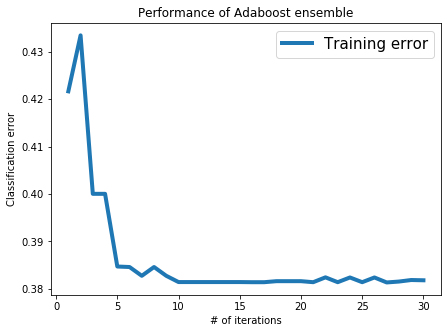

In [25]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

<font color='steelblue'><b> Quiz : Which of the following best describes a **general trend in accuracy** as we add more and more components? Answer based on the 30 components learned so far.

1. Training error goes down monotonically, i.e. the training error reduces with each iteration but never increases.
2. Training error goes down in general, with some ups and downs in the middle.
3. Training error goes up in general, with some ups and downs in the middle.
4. Training error goes down in the beginning, achieves the best error, and then goes up sharply.
5. None of the above </b></font>

<font color='mediumvioletred'><b> Answer : Training error goes down in general, with some ups and downs in the middle. This can be seen seen from the graph above </b></font>

### Evaluation on the test data

Performing well on the training data is cheating, so lets make sure it works on the `test_data` as well. Here, we will compute the classification error on the `test_data` at the end of each iteration.

For n = 1 to 30, do the following:

* Make predictions on test_data using tree stumps 0, ..., n-1.
* Compute classification error for the predictions
* Record the classification error for that n.

In [26]:
test_error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
    test_error = np.sum(np.array(test_data[target]) != predictions) / float(len(predictions))
    test_error_all.append(test_error)
    print("Iteration %s, testing error = %s" % (n, test_error_all[n-1]))

Iteration 1, testing error = 0.4233089185695821
Iteration 2, testing error = 0.42847910383455406
Iteration 3, testing error = 0.3981042654028436
Iteration 4, testing error = 0.3981042654028436
Iteration 5, testing error = 0.3799009047824214
Iteration 6, testing error = 0.38000861697544164
Iteration 7, testing error = 0.3792546316242999
Iteration 8, testing error = 0.38000861697544164
Iteration 9, testing error = 0.3792546316242999
Iteration 10, testing error = 0.37796208530805686
Iteration 11, testing error = 0.37796208530805686
Iteration 12, testing error = 0.37796208530805686
Iteration 13, testing error = 0.37796208530805686
Iteration 14, testing error = 0.37796208530805686
Iteration 15, testing error = 0.37796208530805686
Iteration 16, testing error = 0.37817750969409736
Iteration 17, testing error = 0.37817750969409736
Iteration 18, testing error = 0.3778543731150366
Iteration 19, testing error = 0.3778543731150366
Iteration 20, testing error = 0.3778543731150366
Iteration 21, test

### Visualize both the training and test errors

Now, let us plot the training & test error with the number of iterations.

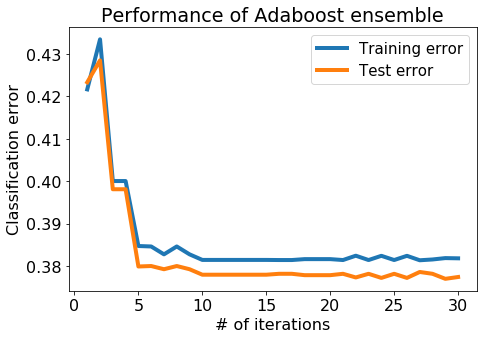

In [27]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()

<font color='steelblue'><b> Quiz : From this plot (with 30 trees), is there massive overfitting as the # of iterations increases? </b></font>

<font color='mediumvioletred'><b> Answer : No, there isn't a massive overfitting as the number of iterations increases </b></font>